In [5]:
import os
import pandas as pd

In [6]:
current_dir = os.getcwd() #current dir
parent_dir = os.path.dirname(current_dir) #parent of current dir

### DATASET A

In [3]:
# Dataset A:  https://www.kaggle.com/datasets/gsimonx37/letterboxd
movies = pd.read_csv(os.path.join(parent_dir,'raw_data/set_a/movies.csv'))
actors = pd.read_csv(os.path.join(parent_dir,'raw_data/set_a/actors.csv'))
crew = pd.read_csv(os.path.join(parent_dir,'raw_data/set_a/crew.csv'))
languages = pd.read_csv(os.path.join(parent_dir,'raw_data/set_a/languages.csv'))
genres = pd.read_csv(os.path.join(parent_dir,'raw_data/set_a/genres.csv'))
studios = pd.read_csv(os.path.join(parent_dir,'raw_data/set_a/studios.csv'))
countries = pd.read_csv(os.path.join(parent_dir,'raw_data/set_a/countries.csv'))

In [5]:
# Dropping the 'tagline' column from movies.csv
movies = movies.drop(columns='tagline', axis=1)

In [6]:
# Dropping the 'role' column and rows with NAN values from actors.csv
actors = actors.drop(columns='role', axis=1)
actors = actors.dropna()

In [8]:
# Filtering the type of languages to be either 'Language' or 'Primary language' and dropping 'Spoken language'
languages = languages[languages['type'].isin(['Language', 'Primary language'])].drop(columns='type')

In [7]:
# Selecting crew members with specific roles, which are thought to be more significant to compress the amount of data
crew = crew[crew['role'].isin(['Director', 'Writer', 'Cinematography', 'Composer'])]

In [9]:
# Creating dictionary for the crew, where keys are the roles and values are the names of people
new_crew = (
    crew.groupby('id')
    .apply(lambda x: x.groupby('role')['name'].apply(list).to_dict())
    .reset_index(name='crew_dict')
)

/tmp/ipykernel_710727/1873594092.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.groupby('role')['name'].apply(list).to_dict())


In [69]:
# Aggregating the genre types for each movie into a list
new_genres = (
    genres.assign(genre=genres['genre'].str.lower().str.replace(' ', '_'))  # Replace spaces within genres with underscores
    .groupby('id')['genre']
    .apply(' '.join)  # Aggregates genres into a single string
    .reset_index(name='genre_list')  # Converts to DataFrame and renames the column
)

# Aggregating the studios that worked on a single movie into a list
new_studios = (
    studios.groupby('id')['studio']
    .apply(list)  # Aggregates the studios into a list
    .reset_index(name='studio_list')  # Converts to DataFrame and renames the column
)

# Aggregating the actors for each movie in a list
new_actors = (
    actors.groupby('id')['name']
    .apply(list)  # Aggregates actors' names into a list
    .reset_index(name='actor_list')  # Converts to DataFrame and renames the column
)

In [70]:
# Merging all the dataframes created from the csv files from Dataset A:  https://www.kaggle.com/datasets/gsimonx37/letterboxd into one dataframe
data = movies\
    .merge(new_genres, how='left', on='id')\
    .merge(new_actors, how='left', on='id')\
    .merge(languages, how='left', on='id')\
    .merge(new_studios, how='left', on='id')\
    .merge(new_crew, how='left', on='id')

In [71]:
# CLEANUP A
data = data.dropna(subset=['date'])
data['date'] = data['date'].astype(int)
data = data.loc[data['name'] != 'Untitled'] #to be completed
data = data.loc[data['date'] <= 2024]

In [72]:
data['key_b'] = data['name'] + data['date'].apply(
    lambda x: f" ({int(x)})" if not pd.isna(x) else ''
    )

In [73]:
check_data = data.groupby('key_b').size().reset_index(name='frequency').sort_values(by='frequency', ascending=False)

In [74]:
unique_keys = data['key_b'].value_counts()  # Count occurrences
unique_keys = unique_keys[unique_keys == 1].index  # Keep only keys with frequency 1
data = data[data['key_b'].isin(unique_keys)] # Filter rows where key_b is unique

In [75]:
del unique_keys

In [76]:
# Saving the new dataframe to a csv file
data.to_csv(os.path.join(parent_dir,'compiled_movies.csv'), index=False)

In [77]:
data = pd.read_csv(os.path.join(parent_dir,'compiled_movies.csv'))

In [128]:
clean_up_data = data.copy()

In [129]:
clean_up_data = clean_up_data.dropna(subset='crew_dict')
clean_up_data = clean_up_data.drop(columns=['studio_list', 'rating'])
clean_up_data = clean_up_data.dropna()

In [130]:
clean_up_data = clean_up_data.drop(columns=['id'], axis=1)

clean_up_data['minute'] = clean_up_data['minute'].astype(int)
clean_up_data['date'] = clean_up_data['date'].astype(int)

clean_up_data = clean_up_data[(clean_up_data.minute > 40) & (clean_up_data.minute <= 240)]

In [132]:
clean_up_data.to_csv(os.path.join(parent_dir,'clean_compile.csv'), index=False)

In [7]:
clean_up_data = pd.read_csv(os.path.join(parent_dir,'clean_compile.csv'))

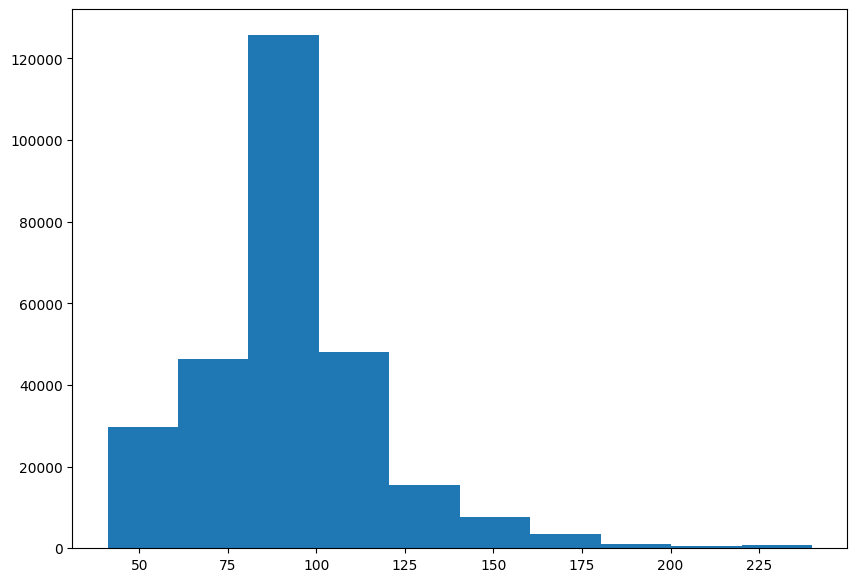

In [83]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.hist(clean_up_data['minute'])

# show plot
plt.show()


In [88]:
from sklearn.preprocessing import MultiLabelBinarizer

encoder = MultiLabelBinarizer()
clean_up_data_temp = pd.DataFrame(encoder.fit_transform(clean_up_data['genre_list'].str.split(' ')),
                                  columns=encoder.classes_,
                                  index=clean_up_data.index)



clean_up_data_temp

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,tv_movie,war,western
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279050,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
279051,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
279052,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
279053,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
